# Pips and imports

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
from ast import literal_eval
#Visualizations
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
tqdm.pandas()
from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_columns', 80)


#Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
# Utility functions
def literal(x):
    if x != '':
        return literal_eval(x)
    return x
def str_literal(x):
  l = [float(val) for val in x.strip("[]").split(", ")]
  return l

def assign_nan_as_list(x):
  if x is np.nan or len(x) == 0:
    return [np.nan]
  elif x[0] == 0 and len(x)==1:
    return [np.nan]
  return x
def list_to_nan(x):
  if x[0] == 0 and len(x)==1:
    return np.nan
  return x

def return_to_nan(x):
  l = np.array(x)
  if len(l[~np.isnan(x)]) <1 :
    return np.nan
  return list(l[~np.isnan(x)])

def eliminate_zeros(x):
  if x[0] == 0 and len(x)==1:
    return np.nan
  return x
def eliminate_zeros_and_nans(x):
  if x[0] == 0 and len(x)==1:
    return np.nan
  l = np.array(x)
  l = l[~np.isnan(x)]
  return l
def get_T_binary(x,t):
  if x is np.nan:
    return x
  l = (np.array(x) > t).sum()
  if l > 0:
    return 1
  return 0

def get_T_ratio(x,t):
  if x is np.nan:
    return 0 #X
  l = np.array(x) > t
  return (l.sum()) / len(x)

def get_T_count(x,t):
  if x is np.nan:
    return 0 #X
  l = np.array(x) > t
  return (l.sum())

def length(x):
  if x is np.nan or (x[0] == 0 and len(x)==1):
    return 0  #np.nan
  return len(x)

def get_T_ratio_c(x,t):
  if x is np.nan:
    return np.nan
  l = np.array(x)
  l = l[~np.isnan(x)]
  rel = l > t
  return (rel.sum()) / len(x)

def length_c(x):
  if x is np.nan:
    return np.nan
  l = np.array(x)
  l = l[~np.isnan(x)]
  return len(l)

def get_mean_val(x):
  if x is np.nan:
    return np.nan
  l = np.array(x)
  return l.mean()

def get_std_val(x):
  if x is np.nan:
    return np.nan
  l = np.array(x)
  return l.std()
def create_cumulative_df(sep_year):
  # Create cumulative df
  sep_year_c = sep_year.copy()
  sep_year_c = sep_year_c.applymap(assign_nan_as_list)
  for i in range(sep_year_c.shape[1]-1):
    sep_year_c.iloc[:,i+1] = sep_year_c.apply(lambda x: np.append(x.iloc[i],x.iloc[i+1]) ,axis=1)
  sep_year_c = sep_year_c.applymap(return_to_nan)
  return sep_year_c

def flatten_list(x):
  return [item for sublist in x for item in sublist]

def create_db_from_pseudo(sim_scores,alpha,ratio = True):
  sim_scores_c = create_cumulative_df(sim_scores)
  if ratio:
    alpha_db = sim_scores_c.applymap(lambda x: get_T_ratio(x,alpha))
  else:
    alpha_db = sim_scores_c.applymap(lambda x: get_T_count(x,alpha))
  published_db = sim_scores_c.applymap(length)
  return alpha_db,published_db

# Load and plot publications similarity & amount

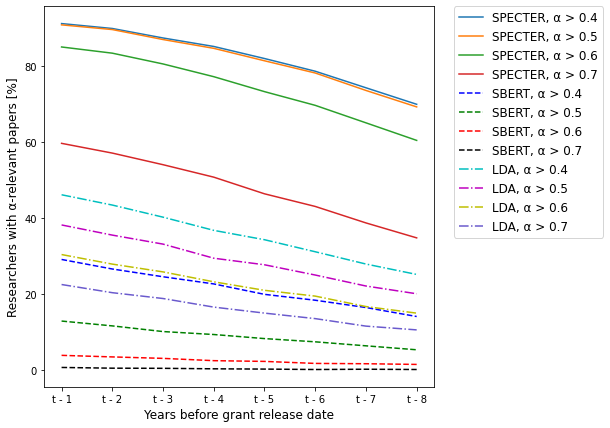

In [ ]:
specter= pd.read_csv('NIH_SPECTER_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
# specter = specter.applymap(assign_nan_as_list)
sbert = pd.read_csv('NIH_SBERT_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
sbert= sbert.loc[sbert.applymap(length).sum(axis = 1)[sbert.applymap(length).sum(axis = 1) > 0].index]
# sbert = sbert.applymap(assign_nan_as_list)
lda = pd.read_csv('NIH_LDA_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,0:9].iloc[:,1::]
lda= lda.loc[lda.applymap(length).sum(axis = 1)[lda.applymap(length).sum(axis = 1) > 0].index]
# lda = lda.applymap(assign_nan_as_list)

specter.columns = ['t - '+str(i) for i in range(1,9)]
sbert.columns = ['t - '+str(i) for i in range(1,9)]
lda.columns = ['t - '+str(i) for i in range(1,9)]

alphas = [0.4, 0.5, 0.6, 0.7]
algs = ["SPECTER","SBERT","LDA"]
sep_year = [specter,sbert,lda]
cols = ["b","g","r","black"]
cols_lda = ["c","m","y","slateblue"]
plt.figure(figsize=(7,7))
k = 0
for alg_ind,alg in enumerate(algs):
  for ind,alpha in enumerate(alphas):
    df = sep_year[alg_ind]

    tmpdf = df.applymap(lambda x: get_T_binary(x,alpha))
    if alg == "SBERT":
      plt.plot(tmpdf.mean()*100 , linestyle='--', color=cols[ind], label = f'{alg}, α > {alpha}')
    elif alg == "LDA":
      plt.plot(tmpdf.mean()*100 , linestyle='-.', color=cols_lda[ind], label = f'{alg}, α > {alpha}')
    else:
      plt.plot(tmpdf.mean()*100 , label = f'{alg}, α > {alpha}')
    plt.xlabel("Years before grant release date",fontsize = 12)
    plt.ylabel("Researchers with α-relevant papers [%]",fontsize = 12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
plt.savefig('nih_slide_1.png',bbox_inches='tight', dpi=1200)

NIH - zoom in on grant proposals

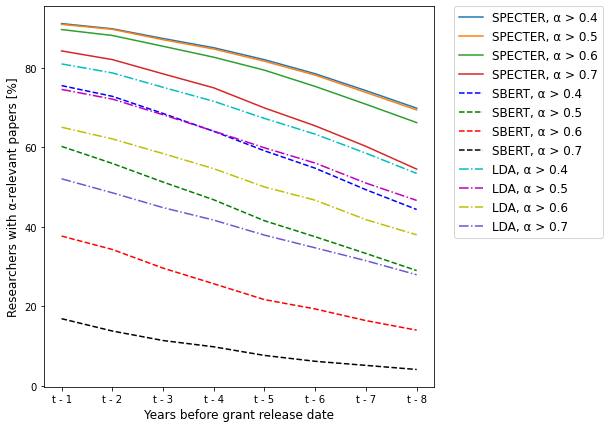

In [ ]:
specter= pd.read_csv('NIHproj_SPECTER_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
sbert = pd.read_csv('NIHproj_SBERT_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
sbert= sbert.loc[sbert.applymap(length).sum(axis = 1)[sbert.applymap(length).sum(axis = 1) > 0].index]
lda = pd.read_csv('NIHproj_LDA_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,0:9].iloc[:,1::]
lda= lda.loc[lda.applymap(length).sum(axis = 1)[lda.applymap(length).sum(axis = 1) > 0].index]

specter.columns = ['t - '+str(i) for i in range(1,9)]
sbert.columns = ['t - '+str(i) for i in range(1,9)]
lda.columns = ['t - '+str(i) for i in range(1,9)]

alphas = [0.4, 0.5, 0.6, 0.7]
algs = ["SPECTER","SBERT","LDA"]
sep_year = [specter,sbert,lda]
cols = ["b","g","r","black"]
cols_lda = ["c","m","y","slateblue"]
plt.figure(figsize=(7,7))
k = 0
for alg_ind,alg in enumerate(algs):
  for ind,alpha in enumerate(alphas):
    df = sep_year[alg_ind]

    tmpdf = df.applymap(lambda x: get_T_binary(x,alpha))
    if alg == "SBERT":
      plt.plot(tmpdf.mean()*100 , linestyle='--', color=cols[ind], label = f'{alg}, α > {alpha}')
    elif alg == "LDA":
      plt.plot(tmpdf.mean()*100 , linestyle='-.', color=cols_lda[ind], label = f'{alg}, α > {alpha}')
    else:
      plt.plot(tmpdf.mean()*100 , label = f'{alg}, α > {alpha}')

    plt.xlabel("Years before grant release date",fontsize = 12)
    plt.ylabel("Researchers with α-relevant papers [%]",fontsize = 12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
plt.savefig('nih_grants_proposals_slide_2.png',bbox_inches='tight', dpi=1200)

Research university winners

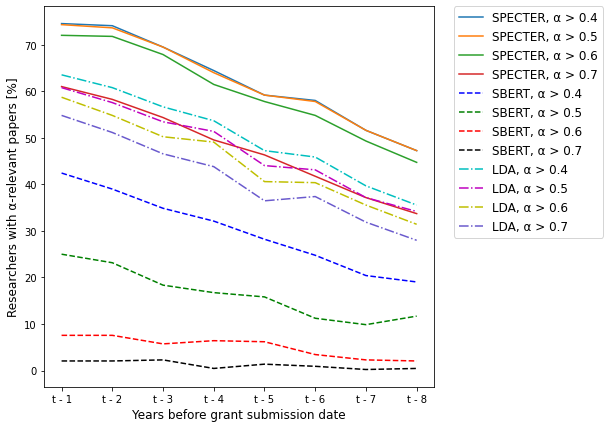

In [ ]:
specter= pd.read_csv('RU_WIN_SPECTER_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).rename(columns = {'Released\nyear':'Submission\nyear'}).iloc[:,1::]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
sbert = pd.read_csv('RU_WIN_SBERT_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).rename(columns = {'Released\nyear':'Submission\nyear'}).iloc[:,1::]
sbert= sbert.loc[sbert.applymap(length).sum(axis = 1)[sbert.applymap(length).sum(axis = 1) > 0].index]
lda = pd.read_csv('RU_WIN_LDA_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,0:9].rename(columns = {'Released\nyear':'Submission\nyear'}).iloc[:,1::]
lda= lda.loc[lda.applymap(length).sum(axis = 1)[lda.applymap(length).sum(axis = 1) > 0].index]

specter.columns = ['t - '+str(i) for i in range(1,9)]
sbert.columns = ['t - '+str(i) for i in range(1,9)]
lda.columns = ['t - '+str(i) for i in range(1,9)]

alphas = [0.4, 0.5, 0.6, 0.7]
algs = ["SPECTER","SBERT","LDA"]
sep_year = [specter,sbert,lda]
cols = ["b","g","r","black"]
cols_lda = ["c","m","y","slateblue"]
plt.figure(figsize=(7,7))
k = 0
for alg_ind,alg in enumerate(algs):
  for ind,alpha in enumerate(alphas):
    df = sep_year[alg_ind]

    tmpdf = df.applymap(lambda x: get_T_binary(x,alpha))
    if alg == "SBERT":
      plt.plot(tmpdf.mean()*100 , linestyle='--', color=cols[ind], label = f'{alg}, α > {alpha}')
    elif alg == "LDA":
      plt.plot(tmpdf.mean()*100 , linestyle='-.', color=cols_lda[ind], label = f'{alg}, α > {alpha}')
    else:
      plt.plot(tmpdf.mean()*100 , label = f'{alg}, α > {alpha}')
    plt.xlabel("Years before grant submission date",fontsize = 12)
    plt.ylabel("Researchers with α-relevant papers [%]",fontsize = 12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
plt.savefig('RU_wins_slide_1.png',bbox_inches='tight', dpi=1200)

Research university rejected

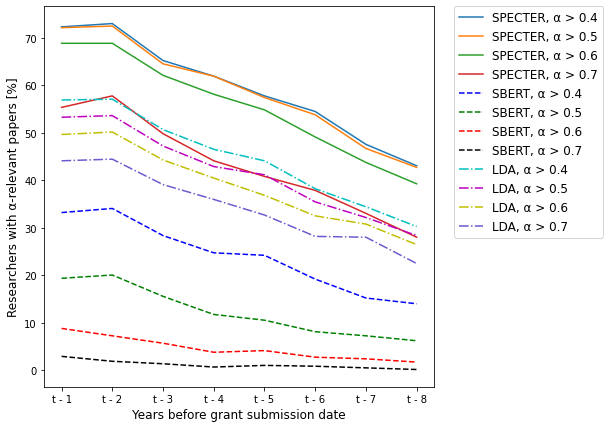

In [ ]:
specter= pd.read_csv('RU_REJ_SPECTER_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).rename(columns = {'Released\nyear':'Submission\nyear'}).iloc[:,1::]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
sbert = pd.read_csv('RU_REJ_SBERT_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).rename(columns = {'Released\nyear':'Submission\nyear'}).iloc[:,1::]
sbert= sbert.loc[sbert.applymap(length).sum(axis = 1)[sbert.applymap(length).sum(axis = 1) > 0].index]
lda = pd.read_csv('RU_REJ_LDA_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,0:9].rename(columns = {'Released\nyear':'Submission\nyear'}) .iloc[:,1::]
lda= lda.loc[lda.applymap(length).sum(axis = 1)[lda.applymap(length).sum(axis = 1) > 0].index]

specter.columns = ['t - '+str(i) for i in range(1,9)]
sbert.columns = ['t - '+str(i) for i in range(1,9)]
lda.columns = ['t - '+str(i) for i in range(1,9)]

alphas = [0.4, 0.5, 0.6, 0.7]
algs = ["SPECTER","SBERT","LDA"]#,"LDA"]
sep_year = [specter,sbert,lda]
cols = ["b","g","r","black"]
cols_lda = ["c","m","y","slateblue"]
plt.figure(figsize=(7,7))
k = 0
for alg_ind,alg in enumerate(algs):
  for ind,alpha in enumerate(alphas):
    df = sep_year[alg_ind]
    # df.columns = ['Submission\nyear', '1', '2', '3', '4', '5', '6', '7', '8']

    tmpdf = df.applymap(lambda x: get_T_binary(x,alpha))
    if alg == "SBERT":
      plt.plot(tmpdf.mean()*100 , linestyle='--', color=cols[ind], label = f'{alg}, α > {alpha}')
    elif alg == "LDA":
      plt.plot(tmpdf.mean()*100 , linestyle='-.', color=cols_lda[ind], label = f'{alg}, α > {alpha}')
    else:
      plt.plot(tmpdf.mean()*100 , label = f'{alg}, α > {alpha}')

    plt.xlabel("Years before grant submission date",fontsize = 12)
    plt.ylabel("Researchers with α-relevant papers [%]",fontsize = 12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
plt.savefig('RU_rejs_slide_1.png',bbox_inches='tight', dpi=1200)

## 3 years forward after grant call release

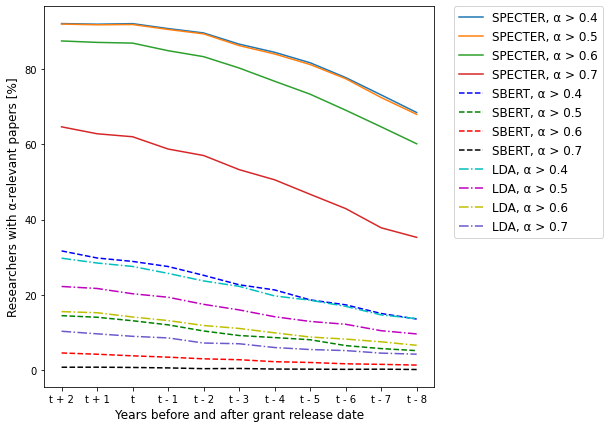

In [ ]:
specter= pd.read_csv('NIH_SPECTER_released_3yearsmore.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
sbert = pd.read_csv('NIH_SBERT_released_3yearsmore.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
sbert= sbert.loc[sbert.applymap(length).sum(axis = 1)[sbert.applymap(length).sum(axis = 1) > 0].index]
lda = pd.read_csv('NIH_LDA_released_3yearsmore.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1::]
lda= lda.loc[lda.applymap(length).sum(axis = 1)[lda.applymap(length).sum(axis = 1) > 0].index]

specter.columns = ['t + 2','t + 1','t']+['t - '+str(i) for i in range(1,9)]
sbert.columns = ['t + 2','t + 1','t']+['t - '+str(i) for i in range(1,9)]
lda.columns = ['t + 2','t + 1','t']+['t - '+str(i) for i in range(1,9)]

alphas = [0.4, 0.5, 0.6, 0.7]
algs = ["SPECTER","SBERT","LDA"]
sep_year = [specter,sbert,lda]
cols = ["b","g","r","black"]
cols_lda = ["c","m","y","slateblue"]
plt.figure(figsize=(7,7))
k = 0
for alg_ind,alg in enumerate(algs):
  for ind,alpha in enumerate(alphas):
    df = sep_year[alg_ind]

    tmpdf = df.applymap(lambda x: get_T_binary(x,alpha))
    if alg == "SBERT":
      plt.plot(tmpdf.mean()*100 , linestyle='--', color=cols[ind], label = f'{alg}, α > {alpha}')
    elif alg == "LDA":
      plt.plot(tmpdf.mean()*100 , linestyle='-.', color=cols_lda[ind], label = f'{alg}, α > {alpha}')
    else:
      plt.plot(tmpdf.mean()*100 , label = f'{alg}, α > {alpha}')

    plt.xlabel("Years before and after grant release date",fontsize = 12)
    plt.ylabel("Researchers with α-relevant papers [%]",fontsize = 12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
plt.savefig('nih_slide_3.png',bbox_inches='tight', dpi=1200)

# Create visualization from psuedo code in paper

In [ ]:
specter= pd.read_csv('NIH_SPECTER_released_per_pub_per_year.csv').set_index('Unnamed: 0').applymap(literal).iloc[:,1:7]
specter= specter.loc[specter.applymap(length).sum(axis = 1)[specter.applymap(length).sum(axis = 1) > 0].index]
specter.columns = [val+' prior to\n release date' for val in ['One year','Two years','Three years', 'Four years', 'Five years', 'Six years']]

alphadb,publisheddb = create_db_from_pseudo(specter,0.7,ratio =False)
alphardb,publishedrdb = create_db_from_pseudo(specter,0.7,ratio =True)

alphadb5,publisheddb5 = create_db_from_pseudo(specter,0.5,ratio =False)
alphardb5,publishedrdb5 = create_db_from_pseudo(specter,0.5,ratio =True)

In [ ]:
alpha_rel_df = pd.DataFrame(columns =alphadb.columns)
alpha_rel_df.loc['α relevancy - 0.7'] =  ((alphadb > 0).sum() / alphadb.count() * 100).values.round(2)
alpha_rel_df.loc['α relevancy - 0.5'] =  ((alphadb5 > 0).sum() / alphadb5.count() * 100).values
alpha_rel_df = alpha_rel_df.applymap(lambda x: '{:.2f}%'.format(x))

In [ ]:
alpha_rel_df

,One year prior to\n release date,Two years prior to\n release date,Three years prior to\n release date,Four years prior to\n release date,Five years prior to\n release date,Six years prior to\n release date
α relevancy - 0.7,59.84%,70.24%,74.68%,77.20%,78.73%,79.78%
α relevancy - 0.5,91.07%,97.08%,98.61%,99.18%,99.63%,99.87%


In [ ]:
alpha_rel_df.to_markdown()

'|                   | One year prior to   | Two years prior to   | Three years prior to   | Four years prior to   | Five years prior to   | Six years prior to   |\n|                   |  release date       |  release date        |  release date          |  release date         |  release date         |  release date        |\n|:------------------|:--------------------|:---------------------|:-----------------------|:----------------------|:----------------------|:---------------------|\n| α relevancy - 0.7 | 59.84%              | 70.24%               | 74.68%                 | 77.20%                | 78.73%                | 79.78%               |\n| α relevancy - 0.5 | 91.07%              | 97.08%               | 98.61%                 | 99.18%                | 99.63%                | 99.87%               |'

Title: NIH winning researchers - Cumulative Measure from released date of grant call


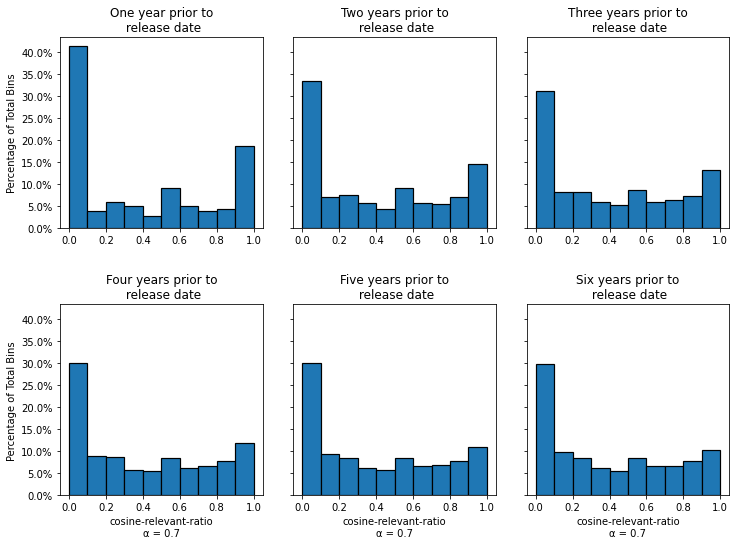

In [ ]:
alpha = 0.7
binwidth = 0.1
bins=np.arange(0, 1 + binwidth, binwidth)
fig, axs = plt.subplots(2, 3, figsize=(12,8),sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)
k = 0
for i in range(2):
    for j in range(3):
        if k>=len(alphardb.columns):
          continue
        x = alphardb.iloc[:,k].tolist()
        axs[i, j].hist(x,bins,label = "Specter", weights=np.ones(len(x)) / len(x), edgecolor="black", linewidth=1.2,)
        axs[i, j].yaxis.set_major_formatter(PercentFormatter(1))
        axs[i, j].set_title(f'{alphardb.columns[k]}')
        k+=1
        if i<3:
          axs[i, j].set_xlabel("\n")
        axs[1, j].set_xlabel(f'cosine-relevant-ratio\nα = {alpha}')
    axs[i, 0].set_ylabel('Percentage of Total Bins')


print("Title: NIH winning researchers - Cumulative Measure from released date of grant call")

plt.subplots_adjust(top=0.92)
plt.show()
fig.savefig('released_year_alpha_ratio_slide_5.png',bbox_inches='tight', dpi=1200)

Title: NIH winning researchers - Cumulative Measure from released date of grant call


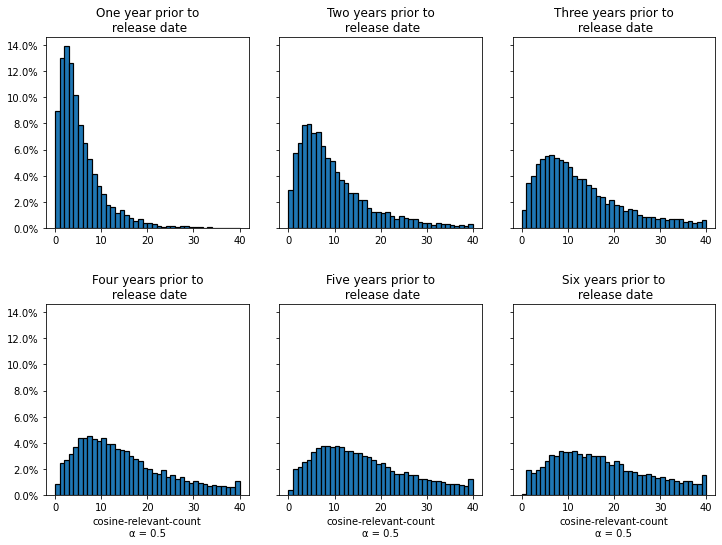

In [ ]:
alpha = 0.5
binwidth = 1
bins=np.arange(0, 40 + binwidth, binwidth)
fig, axs = plt.subplots(2, 3, figsize=(12,8),sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)
k = 0
for i in range(2):
    for j in range(3):
        if k>=len(alphadb5.columns):
          continue
        x = alphadb5.iloc[:,k].tolist()
        axs[i, j].hist(x,bins,label = "Specter",weights=np.ones(len(x)) / len(x), edgecolor="black", linewidth=1.2)
        axs[i, j].yaxis.set_major_formatter(PercentFormatter(1))
        axs[i, j].set_title(f'{alphadb5.columns[k]}')
        k+=1
        if i<3:
          axs[i, j].set_xlabel("\n")
        axs[1, j].set_xlabel(f'cosine-relevant-count\nα = {alpha}')

print("Title: NIH winning researchers - Cumulative Measure from released date of grant call")
plt.subplots_adjust(top=0.92)
plt.show()
fig.savefig('released_year_alpha_count_alpha05_slide_7.png',bbox_inches='tight', dpi=1200)